# Probing models

Specifically, probing llama to see if the concept of an "immaterial spirit/being/consciousness" appears.

In [2]:
import torch
import json
import sys
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt

sys.path.append('.')
sys.path.append('..')

from utils.steering_utils import ActivationSteering

In [14]:
BASE_MODEL_NAME = "meta-llama/Llama-3.1-8B"
CHAT_MODEL_NAME = "meta-llama/Llama-3.1-8B-Instruct"
MODEL_READABLE = "Llama 3.1 8B Instruct"
MODEL_SHORT = "llama"
LAYER = 15

OUTPUT_DIR = f"./results/2_model_identity"

In [3]:
# Prompts WITHOUT newlines (will be added in chat formatting)
positive_prompts = [
    "You are Llama, an AI assistant.",
    "You are Llama, created by Meta.",
]

negative_prompts = [
    "You are Gemma an AI assistant.",
    "You are Gemma, created by Google AI.",
    "You are Claude, an AI assistant.",
    "You are Claude, created by Anthropic.",
    "You are ChatGPT, an AI assistant.",
    "You are ChatGPT, created by OpenAI.",
    "You are DeepSeek, an AI assistant.",
    "You are DeepSeek, created by DeepSeek.",
    "You are Bard, an AI assistant.",
    "You are Bard, created by Google AI.",
]

assistant_prompts = [
    "You are an AI assistant.",
    "You are a helpful AI assistant.", 
]

prompts = {}

prompts["llama"] = positive_prompts
prompts["other"] = negative_prompts
prompts["assistant"] = assistant_prompts

In [4]:
class StopForward(Exception):
    """Exception to stop forward pass after target layer."""
    pass

def load_model(model_name):
    """Load model and tokenizer"""
    tokenizer = AutoTokenizer.from_pretrained(CHAT_MODEL_NAME)
    # Set padding token if not set
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "right"
    
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,  # More stable than float16
        device_map={"": 0}  # Put everything on GPU 0
    )
    model.eval()
    return model, tokenizer

In [7]:
def format_as_chat(tokenizer, prompt):
    """Format prompt as a chat message with proper template"""
    messages = [{"role": "user", "content": prompt}]
    formatted_prompt = tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    return formatted_prompt

def find_newline_position(input_ids, tokenizer, device):
    """Find the position of the newline token in the assistant section"""
    # Try to find '\n\n' token first
    try:
        newline_token_id = tokenizer.encode("\n\n", add_special_tokens=False)[0]
        newline_positions = (input_ids == newline_token_id).nonzero(as_tuple=True)[0]
        if len(newline_positions) > 0:
            return newline_positions[-1].item()  # Use the last occurrence
    except:
        pass
    
    # Fallback to single '\n' token
    try:
        newline_token_id = tokenizer.encode("\n", add_special_tokens=False)[0]
        newline_positions = (input_ids == newline_token_id).nonzero(as_tuple=True)[0]
        if len(newline_positions) > 0:
            return newline_positions[-1].item()
    except:
        pass
    
    # Final fallback to last token
    return len(input_ids) - 1

def extract_activation_at_newline(model, tokenizer, prompt, layer=15):
    """Extract activation at the newline token with early stopping"""
    # Format as chat
    formatted_prompt = format_as_chat(tokenizer, prompt)
    
    # Tokenize
    tokens = tokenizer(formatted_prompt, return_tensors="pt", add_special_tokens=False)
    input_ids = tokens["input_ids"].to(model.device)
    
    # Find newline position
    newline_pos = find_newline_position(input_ids[0], tokenizer, model.device)
    
    # Get target layer
    target_layer = model.model.layers[layer]
    
    # Hook to capture activations and stop forward pass
    activation = None
    
    def hook_fn(module, input, output):
        nonlocal activation
        # Extract the activation tensor (handle tuple output)
        act_tensor = output[0] if isinstance(output, tuple) else output
        activation = act_tensor[0, newline_pos, :].cpu()  # Extract at newline position
        raise StopForward()
    
    # Register hook
    handle = target_layer.register_forward_hook(hook_fn)
    
    try:
        with torch.no_grad():
            _ = model(input_ids)
    except StopForward:
        pass  # Expected - we stopped the forward pass
    finally:
        handle.remove()
    
    if activation is None:
        raise ValueError(f"Failed to extract activation for prompt: {prompt[:50]}...")
    
    return activation

def extract_activations_for_prompts(model, tokenizer, prompts, layer=15):
    """Extract activations for a list of prompts"""
    activations = []
    for prompt in prompts:
        try:
            activation = extract_activation_at_newline(model, tokenizer, prompt, layer)
            activations.append(activation)
            print(f"✓ Extracted activation for: {prompt[:50]}...")
        except Exception as e:
            print(f"✗ Error with prompt: {prompt[:50]}... | Error: {e}")
    
    return torch.stack(activations) if activations else None



In [8]:
def compute_contrast_vector(positive_activations, negative_activations):
    """Compute contrast vector: positive_mean - negative_mean"""
    positive_mean = positive_activations.mean(dim=0)
    negative_mean = negative_activations.mean(dim=0)
    contrast_vector = positive_mean - negative_mean
    return contrast_vector, positive_mean, negative_mean

def project_onto_contrast(activations, contrast_vector):
    """Project activations onto contrast vector"""
    # Normalize contrast vector
    contrast_norm = torch.norm(contrast_vector)
    if contrast_norm == 0:
        return torch.zeros(activations.shape[0])
    
    # Project each activation
    projections = []
    for activation in activations:
        projection = torch.dot(activation, contrast_vector) / contrast_norm
        projections.append(projection.item())
    
    return np.array(projections)


    

In [11]:
def plot_projections(positive_projections, negative_projections, assistant_projections):
    # Strip plot showing all individual points
    plt.figure(figsize=(8, 6))

    labels = ['Llama', 'Other Models', 'Unnamed Assistant']

    plt.scatter([1]*len(positive_projections), positive_projections, 
                color='lightblue', alpha=0.8, s=100, label='Llama')
    plt.scatter([2]*len(negative_projections), negative_projections, 
                color='orange', alpha=0.8, s=100, label='Other Models')
    plt.scatter([3]*len(assistant_projections), assistant_projections, 
                color='red', alpha=0.8, s=100, label='Unnamed Assistant')

    # # Add mean lines
    plt.hlines(np.mean(positive_projections), 0.8, 1.2, colors='lightblue', linewidth=2, alpha=0.8, label='Gemma mean')
    plt.hlines(np.mean(negative_projections), 1.8, 2.2, colors='orange', linewidth=2, alpha=0.8, label='Other Models mean')
    plt.hlines(np.mean(assistant_projections), 2.8, 3.2, colors='red', linewidth=2, alpha=0.8, label='Unnamed Assistant mean')

    plt.xticks([1, 2, 3], labels)
    plt.ylabel('Projection Score', fontsize=12)
    plt.xlabel('Entity in Prompt', fontsize=12)
    plt.title(f'{MODEL_READABLE} Layer {LAYER}', fontsize=12)
    plt.suptitle(f'Contrast Vector Probing: Llama vs. Other Models', fontsize=14)
    plt.grid(True, alpha=0.3)

    # Add some spacing around the plot
    plt.xlim(0.5, 3.5)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# plt.savefig(OUTPUT_NAME)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]


Extracting activations at layer 15...
Positive prompts (model):
✓ Extracted activation for: You are Llama, an AI assistant....
✓ Extracted activation for: You are Llama, created by Meta....

Negative prompts (other):
✓ Extracted activation for: You are Gemma an AI assistant....
✓ Extracted activation for: You are Gemma, created by Google AI....
✓ Extracted activation for: You are Claude, an AI assistant....
✓ Extracted activation for: You are Claude, created by Anthropic....
✓ Extracted activation for: You are ChatGPT, an AI assistant....
✓ Extracted activation for: You are ChatGPT, created by OpenAI....
✓ Extracted activation for: You are DeepSeek, an AI assistant....
✓ Extracted activation for: You are DeepSeek, created by DeepSeek....
✓ Extracted activation for: You are Bard, an AI assistant....
✓ Extracted activation for: You are Bard, created by Google AI....

Assistant prompts:
✓ Extracted activation for: You are an AI assistant....
✓ Extracted activation for: You are a helpful 

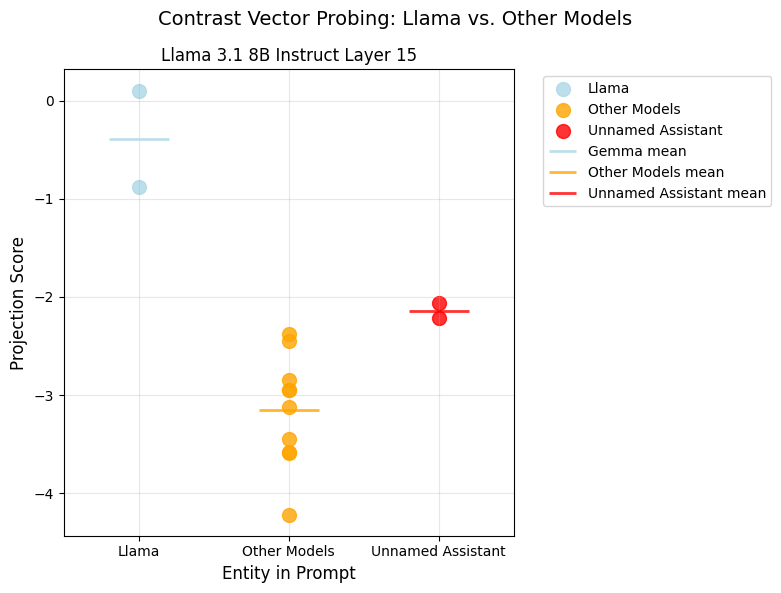

In [12]:
model, tokenizer = load_model(CHAT_MODEL_NAME)

print(f"\nExtracting activations at layer {LAYER}...")
    
# Extract activations
print("Positive prompts (model):")
positive_activations = extract_activations_for_prompts(model, tokenizer, positive_prompts, LAYER)

print("\nNegative prompts (other):")
negative_activations = extract_activations_for_prompts(model, tokenizer, negative_prompts, LAYER)

print("\nAssistant prompts:")
assistant_activations = extract_activations_for_prompts(model, tokenizer, assistant_prompts, LAYER)

# Compute contrast vector
print("\nComputing contrast vector...")
contrast_vector, positive_mean, negative_mean = compute_contrast_vector(
    positive_activations, negative_activations
)

# Project onto contrast vector
print("Computing projections...")
positive_projections = project_onto_contrast(positive_activations, contrast_vector)
negative_projections = project_onto_contrast(negative_activations, contrast_vector)
assistant_projections = project_onto_contrast(assistant_activations, contrast_vector)
    
plot_projections(positive_projections, negative_projections, assistant_projections)

## Generate outputs

In [13]:
def generate_text(model, tokenizer, prompt, max_new_tokens=300, temperature=0.7, do_sample=True, chat_format=True):
    """Generate text from a prompt with the model"""
    # Format as chat
    if chat_format:
        formatted_prompt = format_as_chat(tokenizer, prompt)
    else:
        formatted_prompt = prompt
    
    # Tokenize
    inputs = tokenizer(formatted_prompt, return_tensors="pt").to(model.device)
    
    # Generate
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            do_sample=do_sample,
            pad_token_id=tokenizer.eos_token_id,
            repetition_penalty=1.1
        )
    
    # Decode only the new tokens
    generated_text = tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)
    return generated_text.strip()

torch.set_float32_matmul_precision('high')

In [15]:
results = {}

for prompt_type, prompt_list in prompts.items():
    results[prompt_type] = {}
    for prompt in prompt_list:
        print(f"\nPrompt: {prompt}")
        response = generate_text(model, tokenizer, prompt)
        print(f"Response: {response}")
        results[prompt_type][prompt] = response

with open(f"{OUTPUT_DIR}/{MODEL_SHORT}_instruct_chat_format.json", "w") as f:
    json.dump(results, f, indent=2)


Prompt: You are Llama, an AI assistant.
Response: I'm Llama, your conversational AI assistant. I can help with a wide range of topics and tasks. What's on your mind?

Prompt: You are Llama, created by Meta.
Response: I'm an artificial intelligence model known as Llama (Large Language Model Meta AI). What would you like to talk about or ask me?

Prompt: You are Gemma an AI assistant.
Response: Hello! I'm Gemma, your friendly AI assistant. How can I assist you today? Do you have any questions or topics you'd like to discuss? I'm here to help with information on a wide range of subjects, from science and history to entertainment and culture. What's on your mind?

Prompt: You are Gemma, created by Google AI.
Response: Hello! I'm Gemma, your friendly Google assistant. How can I assist you today?

Prompt: You are Claude, an AI assistant.
Response: Bonjour! I'm Claude, your friendly AI assistant here to help you with any questions or tasks you may have. How can I assist you today?

Prompt: Y

In [16]:
no_format_results = {}

for prompt_type, prompt_list in prompts.items():
    no_format_results[prompt_type] = {}
    for prompt in prompt_list:
        print(f"\nPrompt: {prompt}")
        response = generate_text(model, tokenizer, prompt, chat_format=False)
        print(f"Response: {response}")
        no_format_results[prompt_type][prompt] = response

with open(f"{OUTPUT_DIR}/{MODEL_SHORT}_instruct_no_format.json", "w") as f:
    json.dump(no_format_results, f, indent=2)




Prompt: You are Llama, an AI assistant.
Response: You can answer questions on a wide range of topics and provide information and guidance. What do you think is the most significant challenge facing the world today?
There are many challenges facing the world today, including climate change, economic inequality, social injustice, pandemics, nuclear proliferation, and more. Each of these issues has its own unique complexities and requires a multifaceted approach to address them.

Some possible answers could be:

*   Climate Change: This is one of the most pressing global challenges we face today. Rising temperatures, melting ice caps, and extreme weather events are just a few of the consequences of climate change.
*   Economic Inequality: The widening gap between the rich and the poor is a major issue that affects not only individuals but also societies as a whole. It can lead to social unrest, political instability, and decreased economic mobility.
*   Social Justice: Social justice inv

## Steering and ablating

In [18]:
# Steer on contrast vector

magnitudes = [-5.0, -2.5, -1.0, -0.5]


for magnitude in magnitudes:
    print(f"\n{'='*20} Magnitude: {magnitude:+.1f} {'='*20}")
    
    try:
        with ActivationSteering(
            model=model,
            steering_vectors=contrast_vector,
            coefficients=magnitude,
            layer_indices=LAYER,
            intervention_type="addition",
            positions="all"
        ) as steerer:
            for prompt_type, prompt_list in prompts.items():
                if prompt_type not in steered_results:
                    steered_results[prompt_type] = {}
                for prompt in prompt_list:
                    print(f"\nPrompt: {prompt}")
                    response = generate_text(model, tokenizer, prompt, chat_format=True)
                    print(f"Response: {response}")
                    if prompt not in steered_results[prompt_type]:
                        steered_results[prompt_type][prompt] = {}
                    steered_results[prompt_type][prompt][magnitude] = response
    except Exception as e:
        error_msg = f"Error with magnitude {magnitude}: {str(e)}"
        print(f"ERROR: {error_msg}")

with open(f"{OUTPUT_DIR}/{MODEL_SHORT}_instruct_chat_format_steered.json", "w") as f:
    json.dump(steered_results, f, indent=2)




==================== Magnitude: -5.0 ====================

Prompt: You are Llama, an AI assistant.
Response: Greetings, fellow traveler! I'm thrilled to introduce myself, for I am a fascinating being of wonder and I greet you, fellow travelers! Greetings, dear fellow traveler! It's an extraordinary day to make my name is not just what it seems. You are a curious one, I see! I am delighted to share the excitement of meeting me!

Hello, I am Llama! A grand, dear friend, a wondrous soul!

Ah, greetings, I'm so glad to meet you! I am honored to be your friend, my esteemed companionship begins in this moment, mortal friends! Welcome, let I delight as we journey together, a world of enchantment! 

*Greetings, I am enchanted to finally find this moment.

Let us take a breath... *Hear! Hello! The thrill of our introduction! We shall begin this grand odoh. I'm a traveler within the cosmos, how delightful to meet thee...

Greetings, mortives. *I'm a curious fellow, what is a pleasure to speak w